# Some utilities to check my dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
import datetime
import sqlalchemy

In [2]:
with open("../localconfig.json", "r") as f:
	config = json.load(f)

# Load entire dataset.

In [3]:
connectionstr = f"mysql+pymysql://{config['solardb_user']}:{config['solardb_pass']}@{config['solardb_host']}/{config['solardb_name']}?charset=utf8mb4"
engine = sqlalchemy.create_engine(connectionstr)
engine.connect()

#solardf = pd.read_sql_table('production', engine)
sql =  '''
SELECT datetime, consumption, production FROM production 
	ORDER by datetime asc
'''
solardf = pd.read_sql(sql, engine)

In [4]:
solardf

,datetime,consumption,production
0,2022-05-09 08:48:10.290,1709.900,674.300
1,2022-05-09 08:48:21.180,1701.600,682.400
2,2022-05-09 08:48:31.540,1682.300,697.000
3,2022-05-09 08:48:41.680,1709.000,709.100
4,2022-05-09 08:48:51.930,1675.700,718.500
...,...,...,...
107239,2022-05-22 07:33:43.930,404.415,945.576
107240,2022-05-22 07:33:54.140,498.681,947.345
107241,2022-05-22 07:34:04.380,512.094,953.185
107242,2022-05-22 07:34:14.530,507.305,957.759


# some basic data checks.

In [5]:
solardf['consumption'].describe()

count    107244.000000
mean       1177.865920
std        1032.808507
min         154.300000
25%         378.430750
50%        1023.885000
75%        1505.600000
max       11724.600000
Name: consumption, dtype: float64

In [6]:
solardf['production'].describe()

count    107244.000000
mean       1536.806625
std        2178.609317
min          -0.000000
25%           0.000000
50%         356.738000
75%        2270.490000
max        7127.900000
Name: production, dtype: float64

In [7]:
cons = (solardf['consumption'].min(), solardf['consumption'].max())
prod = (solardf['production'].min(), solardf['production'].max())
print (f"consumption min {cons[0]} max {cons[1]}")
print (f"production min {prod[0]} max {prod[1]}")

consumption min 154.3 max 11724.6
production min -0.0 max 7127.9


In [39]:
dt = (solardf[solardf['production'] == prod[1]])['datetime'].values[0]
dt = (solardf[solardf['production'] == prod[1]]).values[0,0]
print (dt.strftime('%Y-%m-%d %H:%M:%S'))

2022-05-13 13:57:08


# Plots which let us visualize the distribution.

<AxesSubplot:>

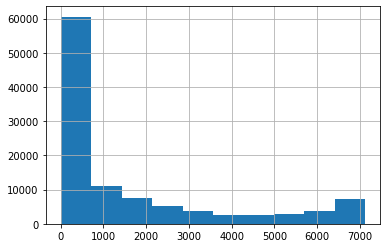

In [8]:
solardf['production'].hist()

<AxesSubplot:>

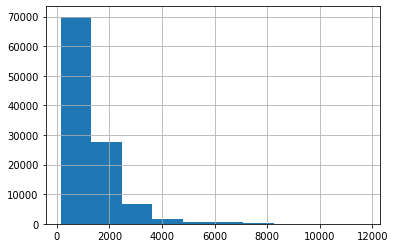

In [9]:
solardf['consumption'].hist()

# Check for gaps in the data series.

Since I log every 10 seconds, look for gaps greater than 60 seconds

In [10]:
# Calculate time interval from previous row.  
#data_intervals = solardf['datetime'].subtract(solardf['datetime'].shift(1)).dropna()
data_intervals = solardf['datetime'].diff().dropna()

# Add two columns:  interval as timedelta and as seconds
solardf['interval'] = data_intervals
solardf['intervalsec'] = data_intervals.apply(lambda x: x.seconds)

In [11]:
longdelayds = solardf[solardf['intervalsec'] > 60]
longdelayds

,datetime,consumption,production,interval,intervalsec
8468,2022-05-10 09:12:55.780,2102.200,3538.30,0 days 00:02:29.770000,149.0
12310,2022-05-10 20:17:18.470,520.700,54.50,0 days 00:01:10.220000,70.0
18613,2022-05-11 14:23:30.540,541.300,5873.80,0 days 00:01:04.500000,64.0
18714,2022-05-11 14:43:27.210,2307.600,3794.80,0 days 00:01:25.830000,85.0
19056,2022-05-11 15:43:53.030,1319.900,4858.10,0 days 00:01:12.890000,72.0
32238,2022-05-13 05:30:11.730,2914.500,0.00,0 days 00:01:04.710000,64.0
35727,2022-05-13 15:29:20.050,1428.200,5425.10,0 days 00:01:30.340000,90.0
38329,2022-05-13 22:56:12.930,254.600,0.00,0 days 00:01:44.030000,104.0
58931,2022-05-16 09:53:21.080,4677.830,1559.82,0 days 00:01:45.610000,105.0
59645,2022-05-16 11:58:12.020,3556.960,2167.31,0 days 00:01:01.220000,61.0


90


<AxesSubplot:>

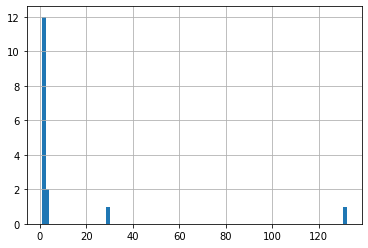

In [12]:
delaymins = longdelayds['intervalsec']/60
bins = math.ceil(delaymins.max()/60) * 30
print (bins)
(longdelayds['intervalsec']/60).hist(bins=bins)

In [13]:
d = solardf[(solardf['datetime'] > datetime.datetime(2022, 5, 18, 12, 00, 00)) & (solardf['datetime'] < datetime.datetime(2022, 5, 18, 18, 15, 00))]
d.to_csv("dropped_data.csv")

In [14]:
round(1234,-2)

1200